In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB3
from keras import layers

In [1]:
import utils

In [2]:
import dataset
dataset = dataset.Dataset()

In [5]:
DATAPATH = 'data/'
IMG_SIZE = 224 
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 32
LABELS = dataset.getLabelList()
# change labels = LABELS for regression
(train_set, test_set) = tf.keras.utils.image_dataset_from_directory(
    DATAPATH,
    image_size = SIZE,
    batch_size = BATCH_SIZE,
    labels = "inferred",
    label_mode = 'int',
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

['1543', '1539', '1535', '1534', '1553', '1552', '1507', '1516', '1516', '1522', '1516', '1546', '1550', '1549', '1550', '1549', '1556', '1555', '1562', '1563', '1597', '1552', '1559', '1561', '1561', '1563', '1583', '1597', '1588', '1561', '1591', '1588', '1585', '1522', '1527', '1525', '1540', '1560', '1572', '1513', '1571', '1504', '1579', '1587', '1573', '1573', '1593', '1583', '1562', '1593', '1531', '1502', '1519', '1519', '1522', '1573', '1585', '1556', '1502', '1531', '1526', '1526', '1526', '1526', '1511', '1526', '1526', '1521', '1520', '1519', '1519', '1518', '1518', '1518', '1517', '1517', '1517', '1516', '1516', '1516', '1515', '1515', '1515', '1515', '1515', '1519', '1519', '1518', '1518', '1517', '1515', '1515', '1530', '1530', '1526', '1517', '1515', '1514', '1514', '1514', '1514', '1515', '1513', '1513', '1513', '1513', '1512', '1512', '1512', '1511', '1511', '1513', '1511', '1510', '1510', '1509', '1509', '1514', '1514', '1513', '1513', '1512', '1512', '1511', '1510',

In [6]:
print(train_set.class_names)
num_classes = len(train_set.class_names)
num_classes

['-1', '-2', '-3', '-4', '-5', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '3', '4', '5', '6', '7', '8', '9']


24

EfficientNet3 with Sparse Categorical Crossentropy

In [19]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    # layer3 = layers.Dense(units = 256, activation='relu')(dropout)
    # layer2 = layers.Dense(units = 128, activation='relu')(layer3)
    # layer1 = layers.Dense(units = 64, activation='relu')(layer2)
    outputs = layers.Dense(num_classes, activation="softmax")(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNet3 with Mean Absolute Error

In [6]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(units = 1)(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


EfficientNetB3 with MAE, larger fully connected layer

In [10]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    layer3 = layers.Dense(units = 512, activation='relu')(dropout)
    layer2 = layers.Dense(units = 256, activation='relu')(layer3)
    layer1 = layers.Dense(units = 64, activation='relu')(layer2)
    outputs = layers.Dense(units = 1)(layer1)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=["mean_absolute_error"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model from [this](https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow) StackOverflow post. <br>
This uses a regression model.

In [7]:
augmentation_layer = tf.keras.Sequential([                                    
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
], name='data_augmentation')  

model = tf.keras.Sequential([
    augmentation_layer,
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mean_absolute_error'])

Network from [This](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) paper _without_ multi GPU: <br>
5 Conv layers followed by 3 fully connected layers. Afer each fully connected layer, a ReLu unit is used as nonlinearity. Additionally normalization and dropout are applied 
(found via [Image Orientation Estimation with Convolutional Networks](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). <br>
**Not Implemented**: 
- Multiple GPUs
- First Layers with Stride of 4

Other hyper parameters to change: 
- Batch size of 128
- 90 cycles through the training set

In [ ]:
callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)] # Paper does not specify the patience, so I chose 5
optimizer = tf.keras.optimizers.experimental.SGD(weight_decay=0.0005, learning_rate=0.01, momentum=0.9)

one_bias_initializer = tf.keras.initializers.Constant(value=1)
zero_bias_initializer = tf.keras.initializers.Constant(value=0)

KrizhevskyModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(5, 5, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
])

KrizhevskyModel.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
EPOCHS = 30

EfficientNet

In [20]:
histEfficientNet = modelEfficientNet.fit(train_set, epochs=EPOCHS, validation_data=test_set) 

Epoch 1/30
560/560 [==============================] - 3705s 7s/step - loss: 1.7300 - accuracy: 0.5298 - val_loss: 1.1650 - val_accuracy: 0.6079
Epoch 2/30
560/560 [==============================] - 3613s 6s/step - loss: 1.1893 - accuracy: 0.6411 - val_loss: 2.2953 - val_accuracy: 0.6242
Epoch 3/30
560/560 [==============================] - 3616s 6s/step - loss: 0.8040 - accuracy: 0.7311 - val_loss: 0.7235 - val_accuracy: 0.7532
Epoch 4/30
560/560 [==============================] - 3600s 6s/step - loss: 0.6719 - accuracy: 0.7721 - val_loss: 0.6990 - val_accuracy: 0.7599
Epoch 5/30
560/560 [==============================] - 3581s 6s/step - loss: 0.5564 - accuracy: 0.8102 - val_loss: 0.7247 - val_accuracy: 0.7642
Epoch 6/30
560/560 [==============================] - 3580s 6s/step - loss: 0.5119 - accuracy: 0.8254 - val_loss: 0.8733 - val_accuracy: 0.7805
Epoch 7/30
560/560 [==============================] - 3570s 6s/step - loss: 0.4067 - accuracy: 0.8581 - val_loss: 0.6604 - val_accuracy:

KeyboardInterrupt: 

Model

In [ ]:
histModel = model.fit(train_set, epochs=EPOCHS, validation_data=test_set)

Krizhevsky

In [ ]:
histKrizhevsky = KrizhevskyModel.fit(train_set, epochs=EPOCHS, validation_data=test_set, callbacks=callbacks)

AutoKeras from [this](https://autokeras.com/tutorial/image_regression/) tutorial

In [ ]:
import autokeras as ak

reg = ak.ImageRegressor(overwrite=True, max_trials=5, loss="mean_absolute_error", metrics=["mean_absolute_error"])
reg.fit(train_set, epochs=10)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |False             |image_block_1/normalize
False             |False             |image_block_1/augment
resnet            |resnet            |image_block_1/block_type
False             |False             |image_block_1/res_net_block_1/pretrained
resnet50          |resnet50          |image_block_1/res_net_block_1/version
False             |False             |image_block_1/res_net_block_1/imagenet_size
0.25              |0.25              |regression_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate

Epoch 1/10
33/33 [==============================] - 170s 5s/step - loss: 1461.0618 - mean_absolute_error: 1461.0618 - val_loss: 1650.1598 - val_mean_absolute_error: 1650.1598
Epoch 2/10
15/33 [============>.................] - ETA: 1:15 - loss: 1460.3790 - mean_absolute_error: 1460.3790

KeyboardInterrupt: 

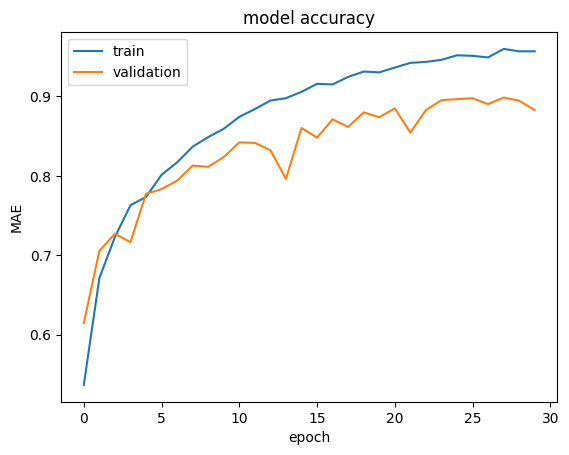

In [ ]:
utils.plot_accuracy(histEfficientNet, "accuracy", "EfficientNetB3")

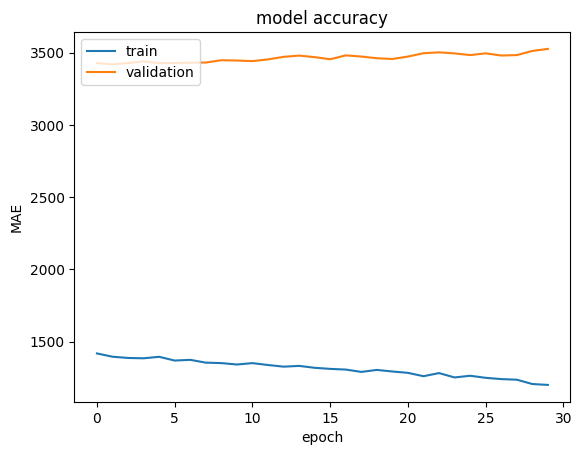

In [12]:
utils.plot_accuracy(histModel, "mean_absolute_error", "Model1")

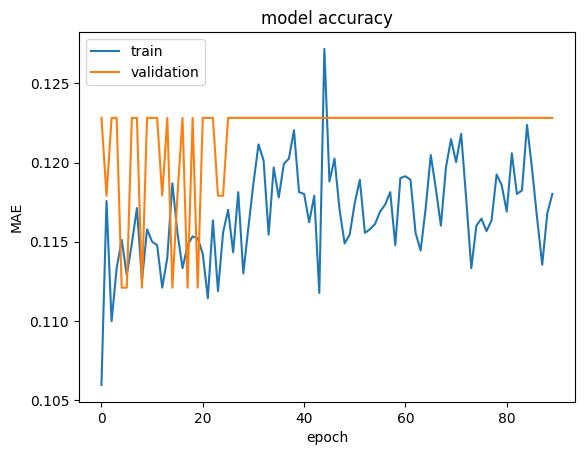

In [55]:
utils.plot_accuracy(histKrizhevsky, "accuracy", "Krizhevsky")